In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ensemble_stack.inference import *
from ensemble_stack.regression.data import load_mapper, one_hot_encode, Validation
from ensemble_stack.regression.models import *
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from sklearn.manifold import TSNE
import random
from sklearn.metrics import mean_squared_error
from Levenshtein import distance as levenshtein_distance
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Neural Network Results (Box Plots)

In [7]:
class Validation(Dataset):
    def __init__(self, lstm=False):
        raw_seqs = np.loadtxt('ensemble_stack/interpreter/data/Test set Regression/valid.tsv', dtype='str')[:, 1]
        enrichment = np.loadtxt('ensemble_stack/interpreter/data/Test set Regression/valid_target.txt')
        enrichment = enrichment.reshape(enrichment.shape[0], 1)
        mapper = load_mapper('ensemble_stack/interpreter/data/mapper')
        if lstm:
            self.x = torch.stack([one_hot_encode(seq, mapper) for seq in raw_seqs]).reshape(-1, 20, 20)
        else:
            self.x = torch.stack([one_hot_encode(seq, mapper) for seq in raw_seqs])
        self.y = torch.from_numpy(np.vstack([x for x in enrichment]))
        self.n_samples = len(raw_seqs)
        

    def __getitem__(self, index):
        return self.x[index].float(), self.y[index].float()

    def __len__(self):
        return self.n_samples

In [4]:
loaded_models = load_all_models()

In [8]:
output = []
mse = []
r_squared = []
pearson = []
gt_enrichment = np.loadtxt('ensemble_stack/interpreter/data/Test set Regression/valid_target.txt')
for idx, model in enumerate(loaded_models.values()):
    if idx > 17:
        dataset = DataLoader(Validation(lstm=True), batch_size=100)
    else:
        dataset = DataLoader(Validation(), batch_size=100)

    model.eval()

    predictions = []
    for step, data in enumerate(dataset):
        inputs, labels = data
        if idx <=17:
            inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs).flatten()

        predictions.append(out.tolist())

    predictions = np.concatenate(predictions)
    mse.append(mean_squared_error(gt_enrichment, predictions))
    r_squared.append(r2_score(gt_enrichment, predictions))
    pearson.append(pearsonr(gt_enrichment, predictions)[0])
# output = np.vstack(output)
# output = output.reshape(output.shape[0], output.shape[1]).T

In [9]:
stacked_pred = get_stacked_prediction(['JJJJIVADEHSSGFDYJJJJ']).flatten()

[[-0.8681793  -1.0341876  -0.81706434 -0.8419023  -0.8725879  -0.93172604
  -0.7903155  -0.97576606 -0.7352452  -0.88054496 -1.0544447  -1.0158432
  -0.8966959  -0.93727875 -1.0561938  -0.8202735  -1.1455891  -1.0567415
  -0.8232312  -0.9331373  -0.74449944 -0.8066835  -0.98786604 -0.79836094
  -0.8309672  -0.9223662  -0.79526114]]


In [10]:
stacked_pred

tensor([-0.7752], grad_fn=<ReshapeAliasBackward0>)

In [11]:
raw_seqs = np.loadtxt('ensemble_stack/interpreter/data/Test set Regression/valid.tsv', dtype='str')[:, 1]
stacked_pred = get_stacked_prediction(raw_seqs).flatten()
stacked_r2 = r2_score(gt_enrichment, stacked_pred.detach().numpy())
stacked_pearson = pearsonr(gt_enrichment, stacked_pred.detach().numpy())
stacked_mse = mean_squared_error(gt_enrichment, stacked_pred.detach().numpy())

[[-0.41101947 -0.74136966 -0.5340222  ... -0.6430346  -0.93902737
  -0.75775766]
 [-0.61122686 -0.7517088  -0.6627606  ... -0.6886494  -0.8887134
  -0.8608643 ]
 [ 0.9775206   0.9062927   0.5458846  ...  0.43801588  1.3227113
   0.29639867]
 ...
 [-0.7191045  -0.8902833  -0.7509951  ... -0.8289388  -0.7749032
  -0.6845702 ]
 [ 0.91011983  1.1807691   0.7779985  ...  0.8672134   1.053822
   0.4339682 ]
 [-0.7709415  -0.9300566  -0.84497863 ... -0.68427926 -0.87686294
  -0.73520833]]


Text(6.800000000000004, 0.5, 'Mean Squared Error')

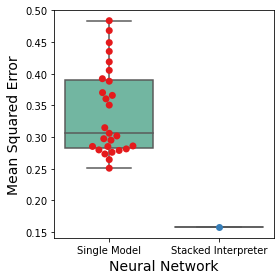

In [159]:
plt.figure(figsize=(4,4), tight_layout=True)

mse_df = pd.DataFrame(columns=['Single Model', 'Stacked Interpreter'])
mse_df['Single Model'] = mse
mse_df.loc[0, 'Stacked Interpreter'] = stacked_mse

ax = sns.boxplot(data=mse_df, palette='Set2', showfliers=False)
ax1 = sns.swarmplot(data=mse_df, palette='Set1', s=7)
ax1.set_xlabel("Neural Network", fontsize = 14)
ax1.set_ylabel("Mean Squared Error", fontsize = 14)

Text(6.800000000000004, 0.5, '$R^2$')

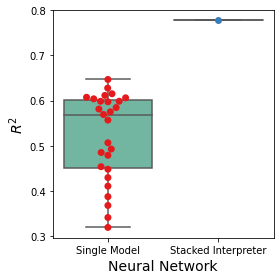

In [162]:
plt.figure(figsize=(4,4), tight_layout=True)

r2_df = pd.DataFrame(columns=['Single Model', 'Stacked Interpreter'])
r2_df['Single Model'] = r_squared
r2_df.loc[0, 'Stacked Interpreter'] = stacked_r2

ax = sns.boxplot(data=r2_df, palette='Set2', showfliers=False)
ax1 = sns.swarmplot(data=r2_df, palette='Set1', s=7)
ax1.set_xlabel("Neural Network", fontsize = 14)
ax1.set_ylabel("$R^2$", fontsize = 14)

Text(6.800000000000004, 0.5, 'Pearson R')

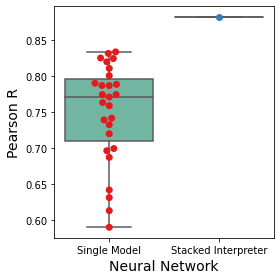

In [163]:
plt.figure(figsize=(4,4), tight_layout=True)

pearson_df = pd.DataFrame(columns=['Single Model', 'Stacked Interpreter'])
pearson_df['Single Model'] = pearson
pearson_df.loc[0, 'Stacked Interpreter'] = stacked_pearson[0]

ax = sns.boxplot(data=pearson_df, palette='Set2', showfliers=False)
ax1 = sns.swarmplot(data=pearson_df, palette='Set1', s=7)
ax1.set_xlabel("Neural Network", fontsize = 14)
ax1.set_ylabel("Pearson R", fontsize = 14)

# Stacked Prediction Scatterplot

In [15]:
pred_enrichment = stacked_pred.detach().numpy()
enrichment = np.loadtxt('ensemble_stack/interpreter/data/Test set Regression/valid_target.txt')

In [19]:
x = pred_enrichment
y = enrichment
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()

In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                 2.362e+04
Date:                Sat, 15 Oct 2022   Prob (F-statistic):               0.00
Time:                        13:19:16   Log-Likelihood:                -3294.1
No. Observations:                6691   AIC:                             6592.
Df Residuals:                    6689   BIC:                             6606.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0117      0.005     -2.239      0.025      -0.022      -0.001
x1             1.0213      0.007    153.682      0.000       1.008       1.034
==============================================================================
Omnibus:                     1242.361   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3947.430
Skew:                           0.945   Prob(JB):                         0.00
Kurtosis:                       6.254   Cond. No.                         1.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
r2_score(enrichment, stacked_pred.detach().numpy())

0.7784972393942051

In [14]:
pearsonr(enrichment, stacked_pred.detach().numpy())

(0.8827760309626885, 0.0)

In [19]:
mean_squared_error(enrichment, stacked_pred.detach().numpy())

0.15729360951762483

Text(0, 0.5, 'Ground Truth Enrichment')

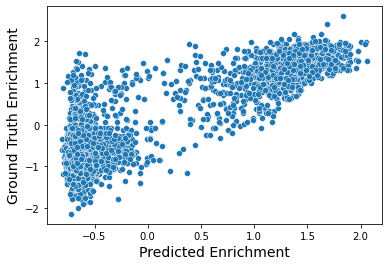

In [25]:
ax = sns.scatterplot(x=stacked_pred.detach().numpy(), y=enrichment)
ax.set_xlabel("Predicted Enrichment", fontsize=14)
ax.set_ylabel("Ground Truth Enrichment", fontsize=14)

# Bar Plots (Comparison to MIT)

Text(0, 0.5, 'Pearson R')

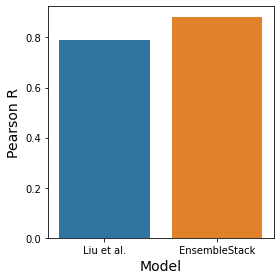

In [164]:
plt.figure(figsize=(4,4), tight_layout=True)
mit_pearsonr = pd.DataFrame({'Pearson R': [0.79, 0.88], 'Model': ['Liu et al.', 'EnsembleStack']})
ax = sns.barplot(x='Model', y='Pearson R', data=mit_pearsonr)
ax.set_xlabel("Model", fontsize=14)
ax.set_ylabel("Pearson R", fontsize=14)

Text(0, 0.5, '$R^2$')

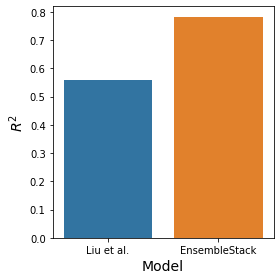

In [165]:
plt.figure(figsize=(4,4), tight_layout=True)
mit_r_squared = pd.DataFrame({'R squared': [0.56, 0.78], 'Model': ['Liu et al.', 'EnsembleStack']})
ax = sns.barplot(x='Model', y='R squared', data=mit_r_squared)
ax.set_xlabel("Model", fontsize=14)
ax.set_ylabel("$R^2$", fontsize=14)

Text(0, 0.5, 'MSE')

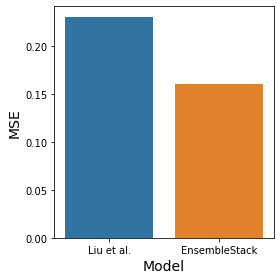

In [166]:
plt.figure(figsize=(4,4), tight_layout=True)
mit_mse= pd.DataFrame({'MSE': [0.23, 0.16], 'Model': ['Liu et al.', 'EnsembleStack']})
ax = sns.barplot(x='Model', y='MSE', data=mit_mse)
ax.set_xlabel("Model", fontsize=14)
ax.set_ylabel("MSE", fontsize=14)

# TSNE Plot

In [10]:
Y_train = np.loadtxt('ensemble_stack/regression/data/Hold out Top 4%/data.target')
np.sum(Y_train >= 0, axis=0)

11726

In [33]:
enrichment_0 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_0.tsv', sep='\t')['enrichment']
enrichment_1 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_1.tsv', sep='\t')['enrichment']
enrichment_2 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_2.tsv', sep='\t')['enrichment']
enrichment_3 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_3.tsv', sep='\t')['enrichment']
enrichment_4 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_4.tsv', sep='\t')['enrichment']

In [147]:
train_data = np.loadtxt('ensemble_stack/regression/data/Test set Regression/test.tsv', dtype='str')[:, 1]
mapper = load_mapper('ensemble_stack/regression/data/mapper')
X_train = torch.stack([one_hot_encode(seq, mapper) for seq in train_data]).numpy()
Y_train = np.loadtxt('ensemble_stack/regression/data/Test set Regression/test_target.txt')
# Y_train = enrichment_4
best_X = []
best_Y = []

for seq, enrichment in zip(X_train, Y_train):
    if enrichment > 0:
        best_X.append(seq)
        best_Y.append(enrichment)
        
best_X = np.asarray(best_X)
best_Y = np.asarray(best_Y)

In [148]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000)
tsne_results = tsne.fit_transform(best_X.reshape((best_X.shape[0], 400)))
df = pd.DataFrame()
df['Enrichment'] = best_Y
df['t-SNE Component 1'] = tsne_results[:,0]
df['t-SNE Component 2'] = tsne_results[:,1]

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4622 samples in 0.003s...
[t-SNE] Computed neighbors for 4622 samples in 0.547s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4622
[t-SNE] Computed conditional probabilities for sample 2000 / 4622
[t-SNE] Computed conditional probabilities for sample 3000 / 4622
[t-SNE] Computed conditional probabilities for sample 4000 / 4622
[t-SNE] Computed conditional probabilities for sample 4622 / 4622
[t-SNE] Mean sigma: 0.742515
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.063690
[t-SNE] KL divergence after 3000 iterations: 0.903692


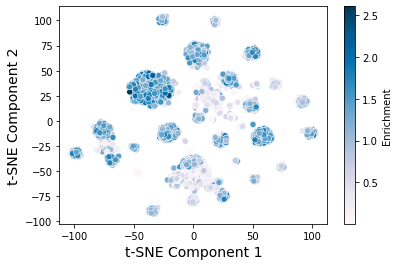

In [153]:
ax = sns.scatterplot(x="t-SNE Component 1", y="t-SNE Component 2", hue="Enrichment", palette="PuBu",
                data=df)
ax.set_xlabel("t-SNE Component 1", fontsize=14)
ax.set_ylabel("t-SNE Component 2", fontsize=14)

norm = plt.Normalize(df['Enrichment'].min(), df['Enrichment'].max())
sm = plt.cm.ScalarMappable(cmap="PuBu", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm, label="Enrichment")
# ax.colorbar.set_label("Hello")
plt.show()

In [136]:
train_data = np.loadtxt('ensemble_stack/regression/data/Full Regression/data.tsv', dtype='str')[:, 1]
mapper = load_mapper('ensemble_stack/regression/data/mapper')
X_train = torch.stack([one_hot_encode(seq, mapper) for seq in train_data]).numpy()
Y_train = np.loadtxt('ensemble_stack/regression/data/Full Regression/data.target')
# Y_train = enrichment_4
worst_X = []
worst_Y = []

for seq, enrichment in zip(X_train, Y_train):
    if enrichment < 0:
        worst_X.append(seq)
        worst_Y.append(enrichment)
        
worst_X = np.asarray(worst_X)
worst_Y = np.asarray(worst_Y)

In [137]:
# train_data = np.loadtxt('ensemble_stack/regression/data/Full Regression/data.tsv', dtype='str')[:, 1]
seq_4 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_4.tsv', sep='\t')['cdr3']
buffered = [seq.center(20, 'J') for seq in seq_4]
mapper = load_mapper('ensemble_stack/regression/data/mapper')
X_train = torch.stack([one_hot_encode(seq, mapper) for seq in buffered]).numpy()
# Y_train = np.loadtxt('ensemble_stack/regression/data/Full Regression/data.target')
Y_train = enrichment_4
best_X = []
best_Y = []

for seq, enrichment in zip(X_train, Y_train):
    if enrichment:
        best_X.append(seq)
        best_Y.append(enrichment)
        
best_X = np.asarray(best_X)
best_Y = np.asarray(best_Y)

In [138]:
all_X = np.concatenate((worst_X, best_X))
all_Y = np.concatenate((worst_Y, best_Y))

In [141]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000)
tsne_results = tsne.fit_transform(all_X.reshape((all_X.shape[0], 400)))
df = pd.DataFrame()
df['Enrichment'] = all_Y
df['t-SNE Component 1'] = tsne_results[:,0]
df['t-SNE Component 2'] = tsne_results[:,1]

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 68052 samples in 0.017s...
[t-SNE] Computed neighbors for 68052 samples in 90.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 68052
[t-SNE] Computed conditional probabilities for sample 2000 / 68052
[t-SNE] Computed conditional probabilities for sample 3000 / 68052
[t-SNE] Computed conditional probabilities for sample 4000 / 68052
[t-SNE] Computed conditional probabilities for sample 5000 / 68052
[t-SNE] Computed conditional probabilities for sample 6000 / 68052
[t-SNE] Computed conditional probabilities for sample 7000 / 68052
[t-SNE] Computed conditional probabilities for sample 8000 / 68052
[t-SNE] Computed conditional probabilities for sample 9000 / 68052
[t-SNE] Computed conditional probabilities for sample 10000 / 68052
[t-SNE] Computed conditional probabilities for sample 11000 / 68052
[t-SNE] Computed conditional probabilities for sample 12000 / 68052
[t-SNE] Computed conditional probabilities for s

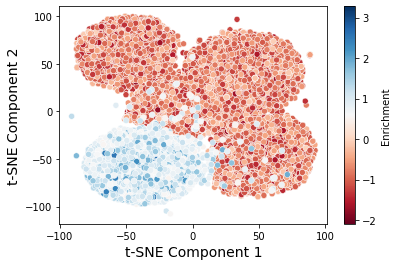

In [142]:
ax = sns.scatterplot(x="t-SNE Component 1", y="t-SNE Component 2", hue="Enrichment", palette="RdBu",
                data=df)
ax.set_xlabel("t-SNE Component 1", fontsize=14)
ax.set_ylabel("t-SNE Component 2", fontsize=14)

norm = plt.Normalize(df['Enrichment'].min(), df['Enrichment'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm, label="Enrichment")
# ax.colorbar.set_label("Hello")
plt.show()

# Iterative Refinement Results

Text(0, 0.5, 'Density')

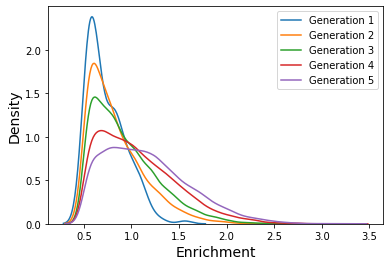

In [56]:
#change to density
#title

ax = sns.kdeplot(enrichment_0, label="Generation 1")
sns.kdeplot(enrichment_1, label="Generation 2")
sns.kdeplot(enrichment_2, label="Generation 3")
sns.kdeplot(enrichment_3, label="Generation 4")
sns.kdeplot(enrichment_4, label="Generation 5")
plt.legend()
ax.set_xlabel("Enrichment", fontsize=14)
ax.set_ylabel("Density", fontsize=14)

In [57]:
ppl_0 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_0.tsv', sep='\t')['perplexity']
ppl_1 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_1.tsv', sep='\t')['perplexity']
ppl_2 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_2.tsv', sep='\t')['perplexity']
ppl_3 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_3.tsv', sep='\t')['perplexity']
ppl_4 = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_4.tsv', sep='\t')['perplexity']

Text(0, 0.5, 'Density')

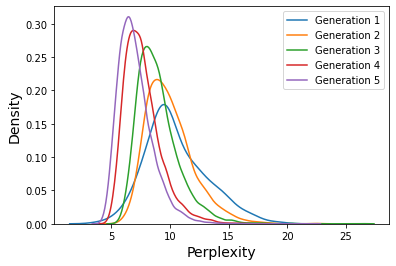

In [167]:
ax = sns.kdeplot(ppl_0, label="Generation 1")
sns.kdeplot(ppl_1, label="Generation 2")
sns.kdeplot(ppl_2, label="Generation 3")
sns.kdeplot(ppl_3, label="Generation 4")
sns.kdeplot(ppl_4, label="Generation 5")
plt.legend()
ax.set_xlabel("Perplexity", fontsize=14)
ax.set_ylabel("Density", fontsize=14)

In [168]:
seed_seqs = pd.read_csv('graph_generation/data/generated/generation2_seqs/top_seeds.csv')[['cdr3']]
seed_seq_counts = {}

for seq in seed_seqs.values:
    seq = seq[0]
    for char in seq:
        if char in seed_seq_counts:
            seed_seq_counts[char] += 1
        else:
            seed_seq_counts[char] =1
            
sorted_seed_seq_counts = {}
for key in sorted(seed_seq_counts):
    sorted_seed_seq_counts[key] = seed_seq_counts[key]

my_df = pd.DataFrame(sorted_seed_seq_counts.items())
total = np.sum(my_df[1])
my_df[1] = my_df.apply(lambda row: (row[1]/total) *100, axis=1)

Text(0, 0.5, 'Frequency (%)')

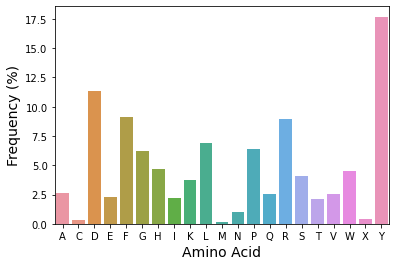

In [170]:
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set_xlabel("Amino Acid", fontsize=14)
ax.set_ylabel("Frequency (%)", fontsize=14)

In [171]:
seqs = pd.read_csv('graph_generation/data/generated/generation2_seqs/3eak_gen_4.tsv', sep='\t')
seq_counts = {}

for seq in seqs.values:
    seq = seq[0]
    for char in seq:    
        if char in seq_counts:
            seq_counts[char] += 1
        else:
            seq_counts[char] =1

sorted_seq_counts = {}
for key in sorted(seq_counts):
    sorted_seq_counts[key] = seq_counts[key]

my_df = pd.DataFrame(sorted_seq_counts.items())
total = np.sum(my_df[1])
my_df[1] = my_df.apply(lambda row: (row[1]/total) *100, axis=1)

Text(0, 0.5, 'Frequency (%)')

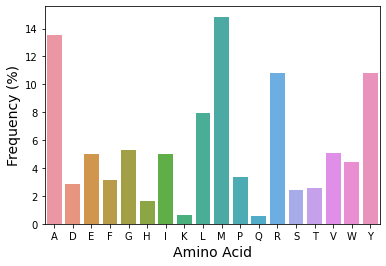

In [172]:
ax = sns.barplot(x=0, y=1, data=my_df)
ax.set_xlabel("Amino Acid", fontsize=14)
ax.set_ylabel("Frequency (%)", fontsize=14)

# Levenshtein Distance Calculation

In [40]:
top_seed = pd.read_csv('graph_generation/data/generated/top_seeds.csv')

In [58]:
stacked_pred = get_stacked_prediction(['AAGRLTRELMMRIYMMEY']).flatten()
stacked_pred

[[ 1.6433437   2.3368015   1.0031015   0.5969304   0.6463889   0.3090757
  -0.23891808 -0.731971    0.02575767 -0.06578612  0.8923342  -0.20970078
   0.14742221 -0.12613535  0.5259703  -0.28005219  0.4969086  -0.03124284
   0.5217184   0.97257006  0.20896983  0.516685    1.2353492   0.33105248
   0.05553456 -0.16965887  0.36183974]]


tensor([0.5455], grad_fn=<ReshapeAliasBackward0>)

In [93]:
min_lev_opt = np.min([levenshtein_distance(seed, "AAGRLTRELMMRIYMMEY") for seed in top_seed['cdr3']])
min_lev_opt

13

In [68]:
# for seed in top_seed['cdr3']:
avg_lev_dist = np.min([levenshtein_distance(seed, "HKPQAVSYLPYRILDY") for seed in top_seed['cdr3']])
avg_lev_dist
#     print(avg_lev_dist)

1

Text(0, 0.5, 'Minimum Levenshtein Distance')

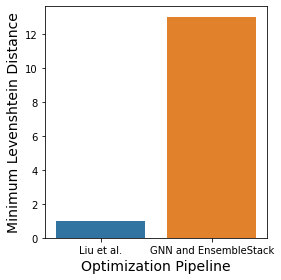

In [177]:
plt.figure(figsize=(4,4), tight_layout=True)
df = pd.DataFrame(columns=['Optimization Pipeline', 'Minimum Levenshtein Distance'])
df['Optimization Pipeline'] = ['Liu et al.', 'GNN and EnsembleStack']
df['Minimum Levenshtein Distance'] = [1, 13]
ax = sns.barplot(x='Optimization Pipeline', y='Minimum Levenshtein Distance', data=df)
ax.set_xlabel("Optimization Pipeline", fontsize=14)
ax.set_ylabel("Minimum Levenshtein Distance", fontsize=14)